In [74]:
#Libaries to Import
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

import matplotlib
import seaborn as sns


In [75]:
#Data 
df = pd.read_csv("data/ebit.csv", delimiter=";", decimal=",")
df.columns = ['year','ebit']
df.head(3)
df.describe()

,ebit
count,93.000000
mean,1051.978495
std,698.579786
min,-448.000000
25%,486.000000
50%,1014.000000
75%,1469.000000
max,2627.000000


In [76]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 2015-01
Time period end: 2022-09


In [77]:
df.columns

Index(['year', 'ebit'], dtype='object')

In [78]:
#Converting to datetime format:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

In [79]:
#Setting index as the datetime column for easier manipulations: 
y = df.set_index('year')
y.index 

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
     

In [80]:
y.isnull().sum()

ebit    0
dtype: int64

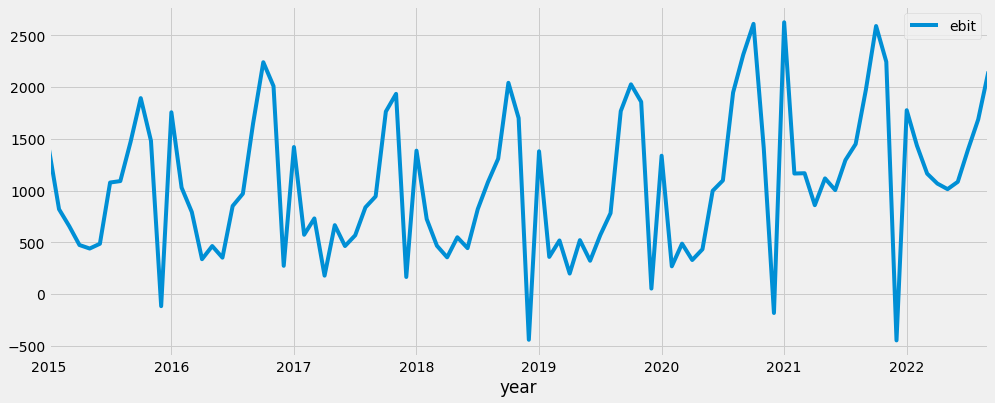

In [81]:
y.plot(figsize=(15, 6))
plt.show()

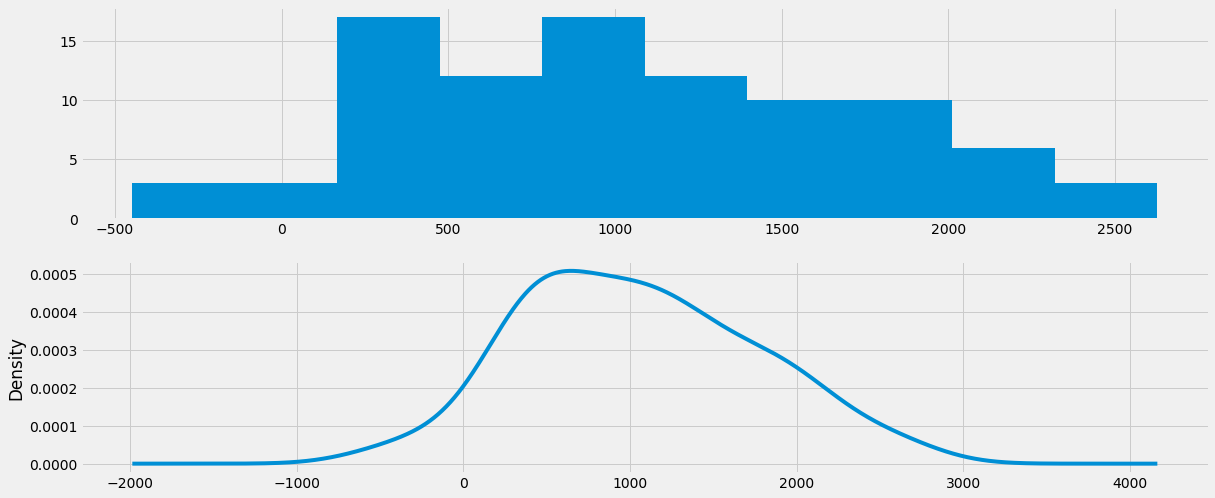

In [82]:
#Reviewing plots of the density of observations can provide further insight into the structure of the data: 
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.ebit.hist()
pyplot.subplot(212)
y.ebit.plot(kind='kde')
pyplot.show()

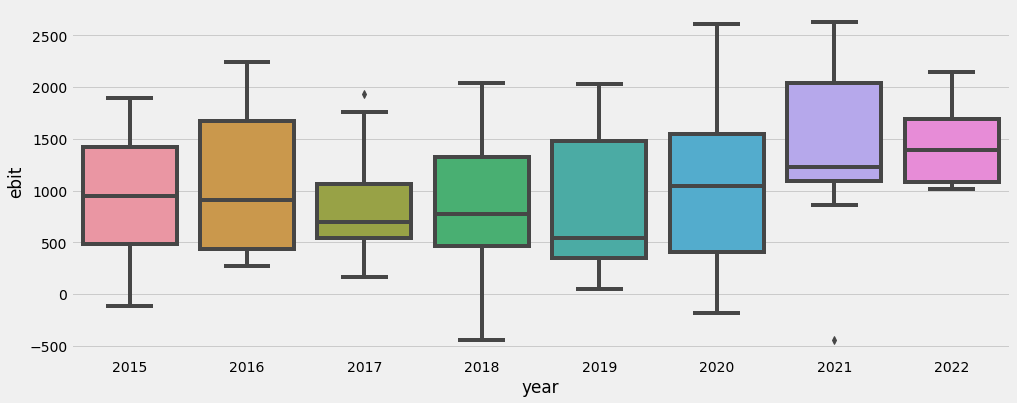

In [83]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.ebit.index.year, y.ebit, ax=ax)

In [84]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()


ValueError: Multiplicative seasonality is not appropriate for zero and negative values

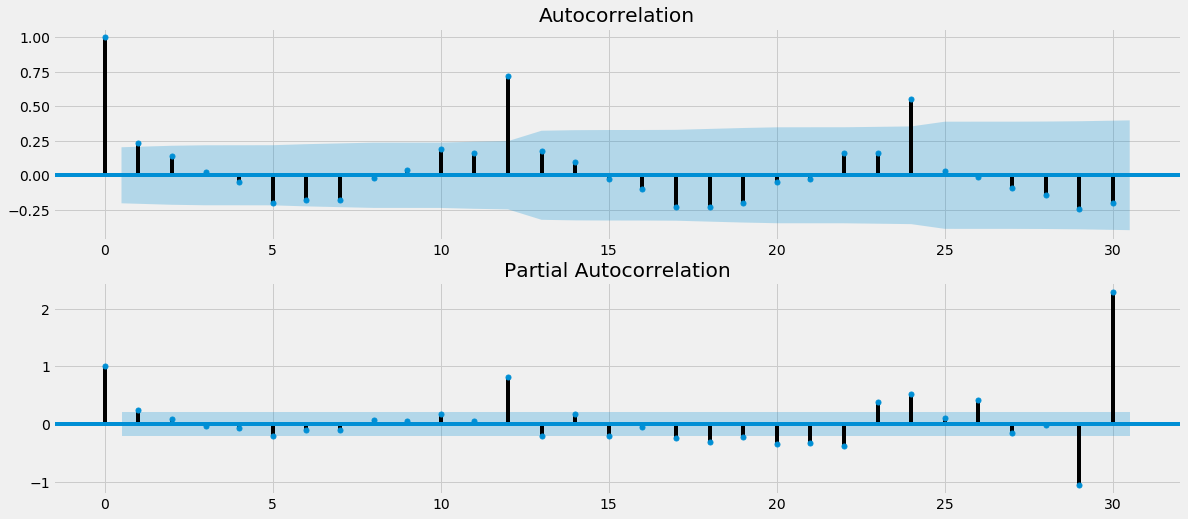

In [85]:
#Stationarity 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.ebit, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.ebit, ax=pyplot.gca(), lags = 30)
pyplot.show()

In [86]:
#Augmented Dickey-Fuller Test & Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.ebit, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)


Results of Dickey-Fuller Test:
Test Statistic                 -0.079141
p-value                         0.951477
#Lags Used                     12.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64


In [87]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [88]:
#ARIMA 
ts = y.ebit - y.ebit.shift()
ts.dropna(inplace=True)

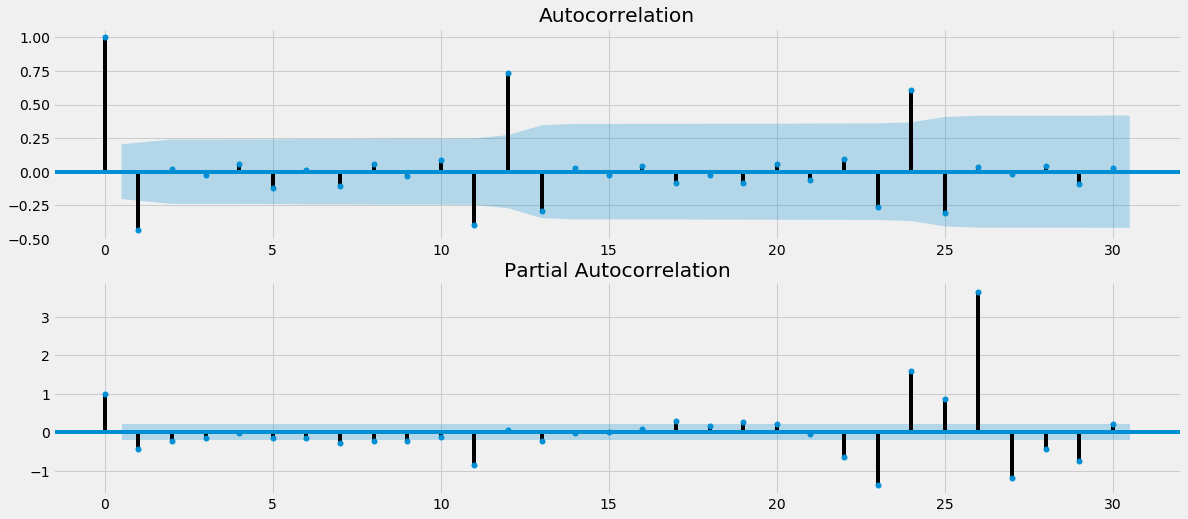

In [89]:
#ACF and PACF plots after differencing:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=30)
pyplot.show()

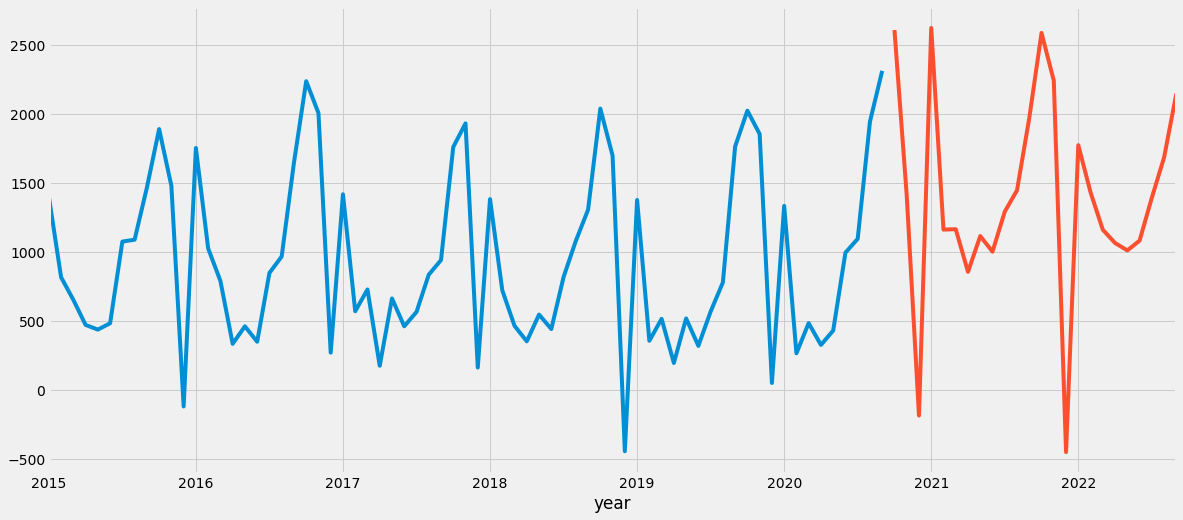

In [92]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['ebit'].plot()
valid['ebit'].plot()

In [93]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=1)

LinAlgError: SVD did not converge

In [94]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.marketing   No. Observations:                   68
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -426.941
Method:                       css-mle   S.D. of innovations            125.875
Date:                Fri, 14 Oct 2022   AIC                            861.883
Time:                        09:08:54   BIC                            870.761
Sample:                    02-01-2015   HQIC                           865.401
                         - 09-01-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.9640      1.318     -1.490      0.136      -4.547       0.619
ar.L1.D.marketing     0.4419      0.111      3.984      0.000       0.224       0.659
ma.L1.D.marketing    -1.0000      0.038    -26.068      0.000      -1.075      -0.925
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.2631           +0.0000j            2.2631            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [95]:
#SARIMA Modeling
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [96]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1149.918390456158
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:1046.980123684359
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:1040.9983190246107
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:886.5620491329937
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:1046.467422592523
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:988.5961097655019
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:827.1904552351776
ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:811.443879971233
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:1108.116070034818
ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:1010.5269009813551
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:1015.7447410903036
ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:863.7733798813214
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:1032.3490025462693
ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:964.9667116767895
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:819.1978434542286
ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:794.604141381788
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:1081.8821351650747
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:992.2274998472354
ARIMA(0, 1, 0)x(0, 1, 0, 

In [97]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              ebit   No. Observations:                   69
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -381.336
Date:                           Fri, 14 Oct 2022   AIC                            772.671
Time:                                   09:09:09   BIC                            782.616
Sample:                               01-01-2015   HQIC                           776.506
                                    - 09-01-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5370      0.220      2.441      0.015       0.106       0.968
ma.L1         -0.9644      0.249     -3.875      0.000      -1.452      -0.477
ar.S.L6       -1.0312      0.021    -48.384      0.000      -1.073      -0.989
ma.S.L6        0.5905      0.220      2.678      0.007       0.158       1.023
sigma2      7.657e+04   1.63e+04      4.710      0.000    4.47e+04    1.08e+05
===================================================================================
Ljung-Box (Q):                       44.47   Jarque-Bera (JB):                 1.23
Prob(Q):                              0.29   Prob(JB):                         0.54
Heteroskedasticity (H):               1.41   Skew:                             0.18
Prob(H) (two-sided):                  0.47   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [151]:
#Period for forecast
start_analysis = "2015-01"
end_analysis = "2023-12"

#Predictions
pred = min_aic_model.get_prediction(start=start_analysis,end=end_analysis, dynamic=False)

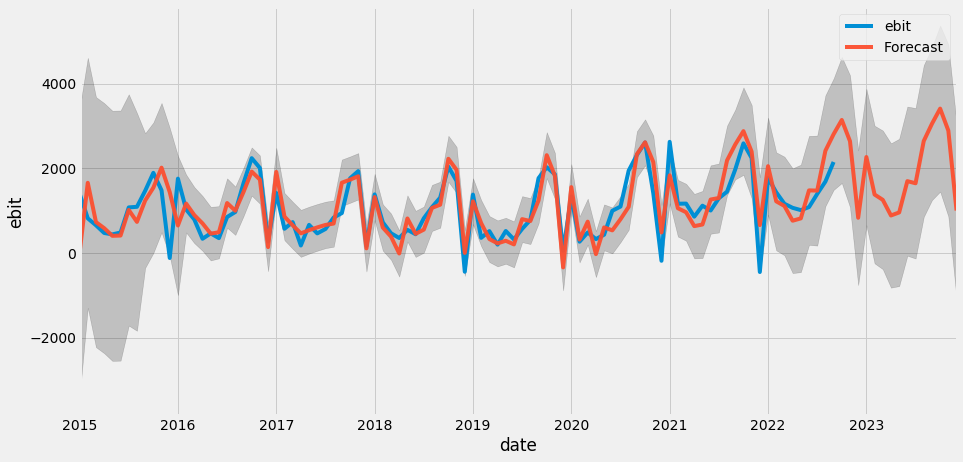

2015-01-01       0.000000
2015-02-01    1658.871311
2015-03-01     730.623859
2015-04-01     587.992624
2015-05-01     406.909729
                 ...     
2023-08-01    2646.527956
2023-09-01    3053.302199
2023-10-01    3411.656053
2023-11-01    2892.490553
2023-12-01    1003.945169
Freq: MS, Length: 108, dtype: float64
             lower ebit   upper ebit
2015-01-01 -3394.757202  3394.757202
2015-02-01 -1293.362834  4611.105455
2015-03-01 -2223.479433  3684.727151
2015-04-01 -2366.245955  3542.231204
2015-05-01 -2547.338632  3361.158090
...                 ...          ...
2023-08-01   855.736812  4437.319100
2023-09-01  1250.501905  4856.102492
2023-10-01  1450.959433  5372.352673
2023-11-01   862.616962  4922.364145
2023-12-01 -1063.669174  3071.559512

[108 rows x 2 columns]


In [152]:
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.95, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('date')
ax.set_ylabel('ebit')
plt.legend()
plt.show()

print(pred.predicted_mean)
print(pred_ci)

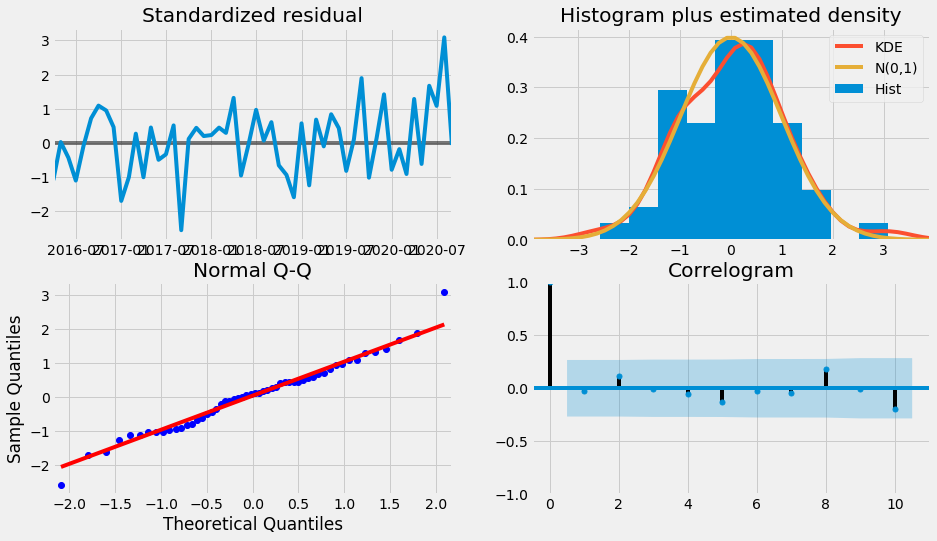

In [146]:
results.plot_diagnostics(figsize=(14, 8))
plt.show()

In [147]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [148]:
#Evaluate Forecast
y_forecasted = pred.predicted_mean.values
y_truth = y[start_analysis:end_analysis].ebit.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 132963.26


In [149]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 364.64


In [150]:
evaluate_forecast(y_truth, y_forecasted)

,r2_score,mean_absolute_error,median_absolute_error,mse,rmse
0,0.760847,273.308532,221.779643,132963.256134,364.64127
